In [15]:
import sys
print(sys.executable)

c:\laragon\www\dsp-attrition-app\venv\Scripts\python.exe


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
# Mengatur agar tampilan plot lebih baik
sns.set_theme(style="whitegrid")


In [17]:
df = pd.read_csv('employee_data.csv')
print("Shape of the dataframe:", df.shape)
print("\nInfo:")
df.info()

Shape of the dataframe: (1470, 35)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   EmployeeId                1470 non-null   int64  
 1   Age                       1470 non-null   int64  
 2   Attrition                 1058 non-null   float64
 3   BusinessTravel            1470 non-null   object 
 4   DailyRate                 1470 non-null   int64  
 5   Department                1470 non-null   object 
 6   DistanceFromHome          1470 non-null   int64  
 7   Education                 1470 non-null   int64  
 8   EducationField            1470 non-null   object 
 9   EmployeeCount             1470 non-null   int64  
 10  EnvironmentSatisfaction   1470 non-null   int64  
 11  Gender                    1470 non-null   object 
 12  HourlyRate                1470 non-null   int64  
 13  JobInvolvement       

## 4. Data Preprocessing
Tahapan ini mencakup:
1.  **Menghapus kolom yang tidak relevan**: Kolom seperti ID karyawan atau kolom dengan nilai yang sama untuk semua baris tidak akan membantu model.
2.  **One-Hot Encoding**: Menerapkan One-Hot Encoding pada fitur kategorikal nominal untuk menghindari model salah menginterpretasikan urutan numerik. Ini adalah implementasi dari **Saran #1**.
3.  **Memisahkan data**: Membagi dataset menjadi dua bagian: satu dengan nilai `Attrition` yang sudah diketahui (untuk melatih model) dan satu lagi yang akan diprediksi.


In [18]:
# 1. Menghapus kolom yang tidak relevan
df_cleaned = df.drop(['EmployeeId', 'EmployeeCount', 'StandardHours', 'Over18'], axis=1)

# 2. One-Hot Encoding untuk fitur kategorikal
categorical_cols = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
df_encoded = pd.get_dummies(df_cleaned, columns=categorical_cols, drop_first=True)

print("Shape of dataframe after encoding:", df_encoded.shape)
print("\nContoh kolom baru hasil encoding:")
print([col for col in df_encoded.columns if 'Department_' in col])

# 3. Memisahkan data berdasarkan nilai Attrition
df_known = df_encoded[df_encoded['Attrition'].notna()].copy()
df_unknown = df_encoded[df_encoded['Attrition'].isna()].copy()

# Mengubah tipe data Attrition menjadi integer untuk training
df_known['Attrition'] = df_known['Attrition'].astype(int)

print(f"\nData yang diketahui Attrition-nya: {df_known.shape[0]} baris")
print(f"Data yang akan diprediksi: {df_unknown.shape[0]} baris")


Shape of dataframe after encoding: (1470, 45)

Contoh kolom baru hasil encoding:
['Department_Research & Development', 'Department_Sales']

Data yang diketahui Attrition-nya: 1058 baris
Data yang akan diprediksi: 412 baris


## 5. Analisis Keseimbangan Kelas (Saran #2)
Sebelum melatih model, penting untuk memeriksa apakah kelas target (Attrition) seimbang. Jika tidak, akurasi saja bisa menjadi metrik yang menipu.


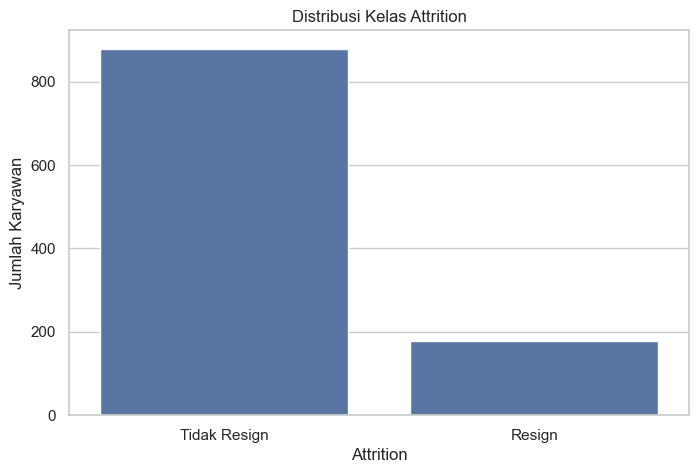

Persentase Distribusi Kelas:
Attrition
0    83.081285
1    16.918715
Name: proportion, dtype: float64


In [19]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Attrition', data=df_known)
plt.title('Distribusi Kelas Attrition')
plt.ylabel('Jumlah Karyawan')
plt.xticks([0, 1], ['Tidak Resign', 'Resign'])
plt.show()

print("Persentase Distribusi Kelas:")
print(df_known['Attrition'].value_counts(normalize=True) * 100)


## 6. Pemodelan
Kita akan menggunakan `RandomForestClassifier` untuk melatih model prediksi. Parameter `class_weight='balanced'` ditambahkan untuk menangani dataset yang tidak seimbang.


In [20]:
# Memisahkan fitur (X) dan target (y)
X = df_known.drop('Attrition', axis=1)
y = df_known['Attrition']

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Inisialisasi dan melatih model
# Menggunakan class_weight='balanced' untuk menangani data imbalance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

print("Model training selesai.")


Model training selesai.


## 7. Evaluasi Model
Meskipun akurasi mungkin sedikit turun dari model awal, **perhatikan nilai `recall` untuk kelas 'Resign'**. Model ini sekarang jauh lebih baik dalam mengidentifikasi karyawan yang benar-benar akan resign, yang merupakan tujuan utama dari analisis ini.


Akurasi Model: 84.43%

Laporan Klasifikasi:
              precision    recall  f1-score   support

Tidak Resign       0.85      0.99      0.91       176
      Resign       0.80      0.11      0.20        36

    accuracy                           0.84       212
   macro avg       0.82      0.55      0.55       212
weighted avg       0.84      0.84      0.79       212



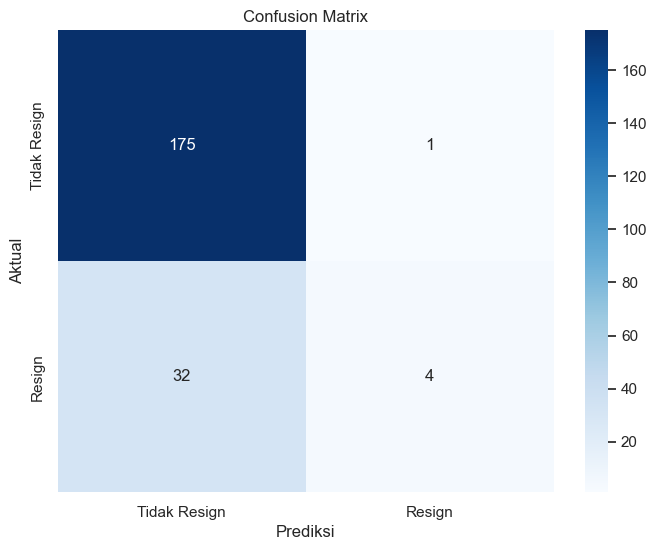

In [21]:
# Melakukan prediksi pada data tes
y_pred = rf_classifier.predict(X_test)

# Menampilkan hasil evaluasi
print(f"Akurasi Model: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred, target_names=['Tidak Resign', 'Resign']))

# Menampilkan Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Tidak Resign', 'Resign'], yticklabels=['Tidak Resign', 'Resign'])
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.title('Confusion Matrix')
plt.show()


## 8. Analisis Faktor Penting (Saran #3)
Sekarang kita akan melihat fitur mana yang dianggap paling penting oleh model dalam membuat prediksi. Ini memberikan wawasan bisnis yang sangat berharga.


10 Fitur Teratas yang Mempengaruhi Attrition:
              Feature  Importance
9       MonthlyIncome    0.069006
0                 Age    0.059350
1           DailyRate    0.058763
43       OverTime_Yes    0.053751
16  TotalWorkingYears    0.052266
10        MonthlyRate    0.049733
5          HourlyRate    0.046500
15   StockOptionLevel    0.043511
2    DistanceFromHome    0.042866
19     YearsAtCompany    0.035132


C:\Users\VivoBook\AppData\Local\Temp\ipykernel_5724\3441320393.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')


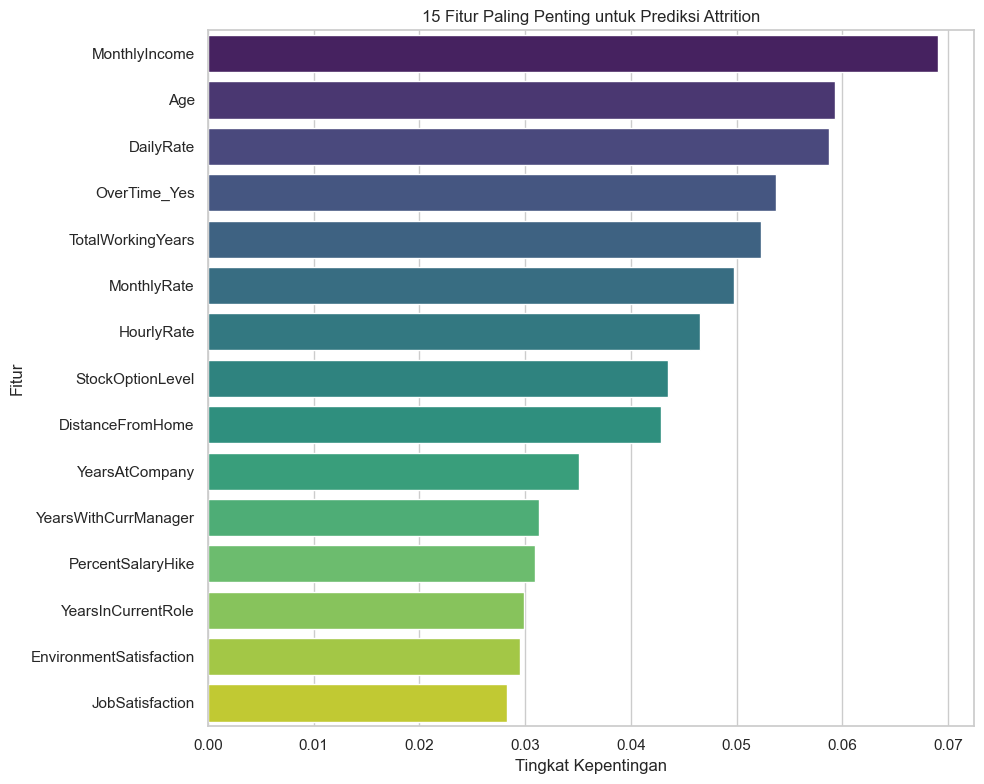

In [22]:
importances = rf_classifier.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("10 Fitur Teratas yang Mempengaruhi Attrition:")
print(feature_importance_df.head(10))

# Visualisasi
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis')
plt.title('15 Fitur Paling Penting untuk Prediksi Attrition')
plt.xlabel('Tingkat Kepentingan')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()


## 9. Prediksi pada Data Baru dan Finalisasi
Langkah terakhir adalah menggunakan model yang telah dilatih untuk memprediksi nilai `Attrition` yang kosong dan menyimpan hasilnya ke file baru.


In [23]:
# Mempersiapkan data yang akan diprediksi
X_unknown = df_unknown.drop('Attrition', axis=1)

# Memastikan urutan kolom sama persis dengan data training
X_unknown = X_unknown[X_train.columns]

# Melakukan prediksi
predictions_unknown = rf_classifier.predict(X_unknown)
print(f"Prediksi selesai untuk {len(predictions_unknown)} karyawan.")

# Mengisi nilai yang kosong pada dataframe asli dengan hasil prediksi
df_final = df_encoded.copy()
df_final.loc[df_final['Attrition'].isna(), 'Attrition'] = predictions_unknown

# Mengubah tipe data kembali menjadi integer
df_final['Attrition'] = df_final['Attrition'].astype(int)

print("\nContoh data setelah diisi:")
print(df_final[df['Attrition'].isna()].head())

# Menyimpan hasil ke file CSV baru
output_file = 'employee_data_predicted.csv'
df_final.to_csv(output_file, index=False)

print(f"\nHasil prediksi telah disimpan ke file '{output_file}'")


Prediksi selesai untuk 412 karyawan.

Contoh data setelah diisi:
    Age  Attrition  DailyRate  DistanceFromHome  Education  \
0    38          0       1444                 1          4   
4    40          0       1194                 2          4   
5    29          0        352                 6          1   
12   47          0        571                14          3   
18   25          0        772                 2          1   

    EnvironmentSatisfaction  HourlyRate  JobInvolvement  JobLevel  \
0                         4          88               3         1   
4                         3          98               3         1   
5                         4          87               2         1   
12                        3          78               3         2   
18                        4          77               4         2   

    JobSatisfaction  ...  JobRole_Laboratory Technician  JobRole_Manager  \
0                 2  ...                          False            Fals

In [24]:
# --- Menyimpan Model dan Kolom ---
# Simpan model ke file
joblib.dump(rf_classifier, 'rf_model.joblib')
print("Model telah disimpan ke 'rf_model.joblib'")

# Simpan daftar kolom yang digunakan saat training
model_columns = X.columns.tolist()
joblib.dump(model_columns, 'model_columns.pkl')
print("Kolom model telah disimpan ke 'model_columns.pkl'")

Model telah disimpan ke 'rf_model.joblib'
Kolom model telah disimpan ke 'model_columns.pkl'
